# NewLanguageModel NEW SIM

This is a new attempt to model a speech community. The old one had some design issues. NEW SIMULATION VERSION

## Library imports

In [1]:
# Import general libraries
from collections import defaultdict
import copy
import time

In [2]:
# Import visualisation libraries
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [3]:
# Import data libraries
from pandas import DataFrame, MultiIndex

In [4]:
# Import statistics libraries
from scipy.stats import poisson, gaussian_kde

In [5]:
# Multithreading
import pathos

# Import mesa libraries
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner, BatchRunnerMP

## Magic numbers

Fagyal et al. cite Dunbar and say that 150 is the "presumed cognitive limit of the number of individuals with whom any one person can maintain regular and stable face-to-face relationships in tight-knit social groups" (p. 2068). Time for constants.

In [6]:
class MagicNumber:
    DUNBAR_NUMBER = 150

## Agent linking infrastructure

### Link
A single link between two agents. Properties are as follows:
- `ends`: two ends of this link `<list:int>`
- `multiplexity`: how many connections bind the agents? `<int>` 

In [7]:
class Link:
    def __init__(self, ends, multiplexity):
        self.ends = ends # e.g. [1, 4], [6, 2]
        self.multiplexity = multiplexity # e.g. 1, 3, 5

### Networked Link Generator

The way in which agents are connected to each other is essential for the type of network we're building, and, as a consequence, for the linguistic properties of this network. Therefore the generators merit their own class. It's also more neat to separate the linking code from the model.

In [8]:
class NetworkedLinkGenerator():
    def __init__(self, friendly_name):
        self.friendly_name = friendly_name
    
    def attach_model(self, model):
        self.model = model
        
        self.links = []
        self.neighbourhood = { str(agent_id):[] for agent_id in range(self.model.num_agents) }
        self.multiplexity_list = { str(agent_id):{} for agent_id in range(self.model.num_agents) }
        
        # Register when this Networked Link Generator was summoned
        # We can use this to check how long the generation took
        self.starting_time = time.time()
        
    # This method facilitates the addition of links by abstracting it.
    # The addition of multiplexity is also handled here.
    def add_link(self, to_id, from_id):
        multiplexity = self.generate_multiplexity()
        
        # Add link
        self.links.append(Link([ to_id, from_id ], multiplexity))
        
        # Add neighbourhood information
        self.add_neighbour(to_id, [ from_id ])
        self.add_neighbour(from_id, [ to_id ])
        
        # Add multiplexity information
        self.add_multiplexity(to_id, from_id, multiplexity)
        self.add_multiplexity(from_id, to_id, multiplexity)
    
    # The structure of the neighbourhood is as follows:
    # agent_id: [ agent_ids of neighbours ]
    def add_neighbour(self, agent_id, neighbours):
        self.neighbourhood[str(agent_id)] = self.neighbourhood[str(agent_id)] + neighbours
    
    # The structure of the multiplexity list is as follows:
    # agent_id: { neighbour_id: multiplexity }
    def add_multiplexity(self, agent_id, neighbour_id, multiplexity):
        self.multiplexity_list[str(agent_id)][str(neighbour_id)] = multiplexity
    
    def generate_multiplexity(self):
        return self.model.random.randint(self.model.multiplexity_range[0],
                                         self.model.multiplexity_range[1])
    
    # Shim for NetworkX's 'neighbors' method
    def neighbours(self, agent_id):          
        return self.neighbourhood[str(agent_id)]
    
    def multiplexity(self, agent_id, neighbour_id):
        return self.multiplexity_list[str(agent_id)][str(neighbour_id)]
    
    def has_link(self, from_id, to_id):
        from_neighbours = self.neighbours(from_id)
        return (to_id in from_neighbours)
    
    def compute_neighbourhood_distribution(self):
        self.neighbour_distribution = [ len(self.neighbours(agent.unique_id)) for agent in self.model.schedule.agents ]
        self.neighbour_distribution.sort()
        
        self.minimum_neighbours = min(self.neighbour_distribution)
        self.maximum_neighbours = max(self.neighbour_distribution)
        
    def compute_average_multiplexity(self):
        multiplexity_list = [ link.multiplexity for link in self.links ]
        self.average_multiplexity = sum(multiplexity_list) / len(multiplexity_list) 
        
    def finish_initialisation(self):
        self.compute_average_multiplexity()
        self.compute_neighbourhood_distribution()
        
        print("Average multiplexity: {}".format(self.average_multiplexity))
        print("Minimum neighbours: {}".format(self.minimum_neighbours))
        print("Maximum neighbours: {}".format(self.maximum_neighbours))
        
        if self.maximum_neighbours > MagicNumber.DUNBAR_NUMBER:
            print("Maximum neighbours in this network exceeds the Dunbar number. Retrying")
            self.attach_model(self.model)
            return
        
        generation_time = time.time() - self.starting_time
        print("Network generation took", str(generation_time), "seconds")

#### Random regular network

A random regular graph is very simple. It doesn't feature any biases, but only makes sure that there is a certain number of nodes in the network, and that each node has a set number of edges.

In [49]:
# This code is based on the NetworkX implementation:
# https://networkx.github.io/documentation/networkx-1.9.1/_modules/networkx/generators/random_graphs.html#random_regular_graph
class RandomRegularNetwork(NetworkedLinkGenerator):
    def __init__(self):
        super().__init__("Random Regular Network")
        
    def attach_model(self, model):
        print("Initialising random regular network")
        super().attach_model(model)
        
        if (self.model.num_agents * self.model.num_edges) % 2 != 0:
            raise "n * d must be even"

        if not 0 <= self.model.num_edges < self.model.num_agents:
            raise "the 0 <= d < n inequality must be satisfied"
        
        # Even though a suitable edge set exists,
        # the generation of such a set is not guaranteed.
        # Try repeatedly to find one.
        edges = self._try_creation()
        while edges is None:
            edges = self._try_creation()
            
        # I convert NetworkX's tuple list to the link model used in this script for two reasons:
        # 1. It would be wasteful to generate multiplexity directly if the chance is high that this specific edge structure will be discarded
        # 2. The tuple structure is needed to efficiently decide whether an edge structure is suitable
        for edge in edges:
            self.add_link(edge[0], edge[1])
            
        self.finish_initialisation()
        
    def _suitable(self, edges, potential_edges):
        # Helper subroutine to check if there are suitable edges remaining
        # If False, the generation of the graph has failed
        if not potential_edges:
               return True
        for s1 in potential_edges:
            for s2 in potential_edges:
                # Two iterators on the same dictionary are guaranteed
                # to visit it in the same order if there are no
                # intervening modifications.
                if s1 == s2:
                    # Only need to consider s1-s2 pair one time
                    break
                if s1 > s2:
                    s1, s2 = s2, s1
                if (s1, s2) not in edges:
                    return True
        return False

    def _try_creation(self):
        # Attempt to create an edge set

        edges = set()
        stubs = list(range(self.model.num_agents)) * self.model.num_edges

        while stubs:
            potential_edges = defaultdict(lambda: 0)
            self.model.random.shuffle(stubs)
            stubiter = iter(stubs)
            for s1, s2 in zip(stubiter, stubiter):
                if s1 > s2:
                    s1, s2 = s2, s1
                if s1 != s2 and ((s1, s2) not in edges):
                    edges.add((s1, s2))
                else:
                    potential_edges[s1] += 1
                    potential_edges[s2] += 1

            if not self._suitable(edges, potential_edges):
                return None # failed to find suitable edge set

            stubs = [node for node, potential in potential_edges.items()
                     for _ in range(potential)]
        
        return edges

#### Barabási–Albert network

A Barabási–Albert graph is guarantees a certain number of edges for each node in the network, but nodes are biased to attach themselves to nodes which already have a large number of edges.

In [10]:
# This code is based on the NetworkX implementation:
# https://networkx.github.io/documentation/networkx-1.9.1/_modules/networkx/generators/random_graphs.html#barabasi_albert_graph
class BarabasiNetwork(NetworkedLinkGenerator):
    def __init__(self):
        super().__init__("Barabási–Albert network")
        
    def attach_model(self, model):
        print("Initialising Barabási–Albert network")
        super().attach_model(model)
        
        # Target nodes for new edges
        targets = list(range(self.model.num_edges))
        
        # List of existing nodes, with nodes repeated once for each adjacent edge (so BOTH NODES at the end of the edge are added!)
        # (this list will be the source for the candidates for new relations)
        # (consequence: nodes with more edges appear more frequently, thus augmenting their 'power' for future connections)
        repeated_nodes = []
        
        # Start by adding the other n-m nodes. The first node is m.
        source = self.model.num_edges
        while source < self.model.num_agents:
            # Create list of tuples with edges to m nodes from the source
            edge_list = zip([source] * self.model.num_edges, targets)
            
            # Create connections
            for edge in edge_list:
                from_node, to_node = edge
                self.add_link(from_node, to_node)
                
            # Add one node to the list for each new edge just created (side ONE of the newly added edges)
            repeated_nodes.extend(targets)
                
            # Add the new node "source" m times to the list, for it just made three connections (side TWO of the newly added edges)
            repeated_nodes.extend([source] * self.model.num_edges)
                
            # Now choose m unique nodes from the existing nodes
            # Pick uniformly from repeated_nodes (preferential attachment)
            # We use a set, because they cannot contain duplicate values (barring the possibility for the same target node being selected multiple times)
            targets=set()
            while len(targets) < self.model.num_edges:
                x = self.model.random.choice(repeated_nodes)
                targets.add(x)
                
            source += 1
            
        self.finish_initialisation()

#### Holme and Kim network

"Basically" Barabási–Albert, but with an extra power law argument. This means that the power law can give rise to clustering if desired. Since clustering is virtually always a given in large speech communities, this is an important addition.

In [11]:
# This code is based on the NetworkX implementation:
# https://networkx.github.io/documentation/networkx-1.9.1/_modules/networkx/generators/random_graphs.html#powerlaw_cluster_graph
class HolmeKimNetwork(NetworkedLinkGenerator):
    def __init__(self, p):
        super().__init__("Holme and Kim network")
        self.p = p

    def attach_model(self, model):
        print("Initialising Holme and Kim network")
        super().attach_model(model)
        
        repeated_nodes = list(range(self.model.num_edges))  # list of existing m initial nodes to sample from
                                                      # with nodes repeated once for each adjacent edge
        
        source = self.model.num_edges # next node is m
        while source < self.model.num_agents: # Now add the other n-1 nodes
            possible_targets = self._random_subset(repeated_nodes, self.model.num_edges)
            
            # Do one preferential attachment for new node
            target = possible_targets.pop()
            self.add_link(source, target)
            
            repeated_nodes.append(target) # add one node to list for each new link
            
            count = 1
            while count < self.model.num_edges:  # add m-1 more new links
                if self.model.random.random() < self.p: # clustering step: add triangle
                    neighborhood = [nbr for nbr in iter(self.neighbours(target)) \
                                   if not self.has_link(source, nbr) \
                                   and not nbr == source]
                    
                    if neighborhood: # if there is a neighbor without a link
                        nbr = self.model.random.choice(neighborhood)
                        self.add_link(source, nbr) # add triangle
                        repeated_nodes.append(nbr)
                        count = count + 1
                        continue # go to top of while loop
                        
                # else do preferential attachment step if above fails
                target = possible_targets.pop()
                self.add_link(source, target)
                repeated_nodes.append(target)
                count = count + 1 
                
            repeated_nodes.extend([source]* self.model.num_edges)  # add source node to list m times
            source += 1
        
        self.finish_initialisation()
    
    # Return m unique elements from seq
    def _random_subset(self, seq, m):
        targets=set()
        while len(targets)<m:
            x=self.model.random.choice(seq)
            targets.add(x)
        return targets

### Network types
This is basically an enum, but Python doesn't support enums.
- `SIMPLE`: a network generated with the "secret santa" algorithm
- `ALBERTO`: a network generated with the Barabási–Albert algorithm
- `POWERLAW`: a network generated with the Holme and Kim algorithm for growing graphs with powerlaw degree distribution and approximate average clustering

In [50]:
class NetworkType:
    SIMPLE = RandomRegularNetwork()
    ALBERTO = BarabasiNetwork()
    POWERLAW = HolmeKimNetwork(0.95)

## Language variant exchange

There are many different ways in which we can model the adaption of a certain language variant. The different models for the exchange of a variant are bundled here.

### Variant exchange

Base class for all exchanges.

In [13]:
class VariantExchange():
    def __init__(self, friendly_name):
        self.friendly_name = friendly_name
    
    def attach_model(self, model):
        self.model = model

### Random exchange

A random exchange of language variants means that the agents in the network do not consciously pay attention to power, relations, multiplexity or other network factors. They simply have a have a certain chance (p value) to adapt the language variant of one of their neighbours.

It should be noted however that there can still be a certain bias because of the network structure. Barabasi networks which feature a certain number of highly-connected agents have such a bias. Because highly-connected agents have a lot of neighbours, they have a higher chance of being the source of an exchange.

- `model`: model to attach this exchange to `<LanguageModel>`
- `p`: chance of exchange (between 0 and 1) `<float>`

In [14]:
class RandomVariantExchange(VariantExchange):
    def __init__(self, p):
        super().__init__("Random variant exchange")
        
        self.p = p
        assert 1 >= p >= 0, "p value should be between 0 and 1"
        
    def try_exchange(self, agent):
        # Simulate random chance
        if self.model.random.random() > self.p:
            return
        
        # Choose a neighbour from the agent's neighbourhood to pick a variant from
        agent_neighbours = self.model.link_generator.neighbours(agent.unique_id)
        chosen_neighbour = self.model.random.choice(agent_neighbours)
        
        agent.variant = self.model.schedule.agents[chosen_neighbour].variant

### Power exchange

This exchange is roughly how exchanging works in Fagyal. The chance of an agent adapting a neighbour's variant is dependent on the number of contacts this neighbour has.

In [15]:
class PowerVariantExchange(VariantExchange):
    def __init__(self):
        super().__init__("Fagyal's power variant exchange")
        
    def try_exchange(self, agent): 
        # Choose a neighbour from the agent's neighbourhood to pick a variant from
        agent_neighbours = self.model.link_generator.neighbours(agent.unique_id)
        chosen_neighbour_id = self.model.random.choice(agent_neighbours)
        chosen_neighbour_first_order_size = len(self.model.link_generator.neighbours(chosen_neighbour_id))
        
        # Number of neighbours of the neighbour's of the agent (~= size of second order zone)
        second_order_zone_size = sum([ len(self.model.link_generator.neighbours(neighbour_id))\
                                       for neighbour_id in agent_neighbours ])
                
        p = chosen_neighbour_first_order_size / second_order_zone_size
        
        if self.model.random.random() < p:
            agent.variant = self.model.schedule.agents[chosen_neighbour_id].variant

### Power exchange with multiplexity

This exchange uses the cumulative distribution function of a Poisson distribution with the average multiplexity of the network as its lambda.

In [16]:
class MultiplexPowerVariantExchange(VariantExchange):
    def __init__(self):
        super().__init__("Multiplexity power variant exchange")
        
    def attach_model(self, model):
        super().attach_model(model)
        
        # There are only a set amount of probabilities for this exchange, and they can be computed in advance
        # In practice, we will only need the probabilities for every multiplexity level in the multiplexity range (m)
        # So, we only need m probabilities computed from the multiplexity average
        self.poisson_cache = { str(multiplexity_level):poisson.cdf(multiplexity_level, self.model.link_generator.average_multiplexity)\
                               for multiplexity_level in range(self.model.multiplexity_range[0], self.model.multiplexity_range[1] + 1, 1) }
        print("Poisson cache:")
        print(self.poisson_cache)
        
    def try_exchange(self, agent): 
        # Choose a neighbour from the agent's neighbourhood to pick a variant from
        agent_neighbours = self.model.link_generator.neighbours(agent.unique_id)
        chosen_neighbour_id = self.model.random.choice(agent_neighbours)
        
        link_multiplexity = self.model.link_generator.multiplexity(agent.unique_id, chosen_neighbour_id)
        
        p = self.poisson_cache[str(link_multiplexity)]
        
        if self.model.random.random() < p:
            agent.variant = self.model.schedule.agents[chosen_neighbour_id].variant

### Exchange types

Again, really just an enum.

In [17]:
class ExchangeType:
    RANDOM = RandomVariantExchange(0.5)
    POWER = PowerVariantExchange()
    MULTIPLEX_POWER = MultiplexPowerVariantExchange()

## Visualisation

There are no social networks without sociograms. These classes take care of the visualisation of networks and language variant distribution.

In [18]:
class Visualisation():
    def __init__(self, model):
        self.model = model
        self.batch_run = model
        
        self.colour_table = [ "red", "green", "blue", "orange", "yellow" ]
        
    def initialise_draw(self):
        plt.figure(figsize=(15, 10))
        
    def draw_histogram(self, data, bin_width=20, x_label=None, y_label=None, title=None):
        self.initialise_draw()
        
        bins = range(int(min(data)), int(max(data) + bin_width), bin_width)
        plt.hist(data, bins=bins)
        
        if x_label and y_label:
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            
        if title:
            plt.title(title)
        
        plt.show()

### Network visualisation

Visualisation of a model's network using NetworkX.

- `model`: the model for which a network visualisation is drawn `<LanguageModel>`
- `with_labels`: whether to draw the agent's unique id in the visualisation `<bool=True>`

In [60]:
class NetworkVisualisation(Visualisation):
    def __init__(self, model, with_labels=True):
        super().__init__(model)
        self.network_pos = None
        self.with_labels = with_labels
               
    def draw(self):
        super().initialise_draw()
        print("Drawing network")
        
        chart_title = "{}\n{} agents, min neighbours = {}, max neighbours = {}\n{} variants".format(self.model.link_generator.friendly_name,
                                                                                       self.model.num_agents,
                                                                                       self.model.link_generator.minimum_neighbours,
                                                                                       self.model.link_generator.maximum_neighbours,
                                                                                       self.model.num_variants)
        
        # Reset the colour map
        colour_map = [ ]
        
        network_graph = nx.Graph()
        network_graph.add_nodes_from([agent.unique_id for agent in self.model.schedule.agents])
        
        for agent in self.model.schedule.agents:
            # Set colour of this node based off the variant they are using
            colour_map.append(self.colour_table[agent.variant])
        
        # Link agents
        for link in self.model.link_generator.links:
            network_graph.add_edge(link.ends[0], link.ends[1])
        
        # We save the network positions, so when we later redraw the same network, the nodes are in the same place for esay comparison
        # https://stackoverflow.com/a/51589014
        if self.network_pos is None:
            self.network_pos = nx.spring_layout(network_graph)
        
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        nx.draw_networkx(network_graph,
                         ax=ax,
                         pos=self.network_pos,
                         node_color=colour_map,
                         font_color='#ffffff',
                         with_labels=self.with_labels)
        ax.set_axis_off()
        plt.title(chart_title)
        plt.pause(0.05)
        plt.show()

### Neighbours count distribution visualisation

Class for plotting the distribution of neighbour count distribution in the network.

In [20]:
class NeighbourCountDistributionVisualisation(Visualisation):
    def __init__(self, model):
        super().__init__(model)
        
    def draw(self):
        print("Drawing neighbour count distribution")
        
        neighbour_distribution = self.model.link_generator.neighbour_distribution
        chart_title = "Neighbour count distribution ({})\n{} agents, min neighbours = {}, max neighbours = {}".format(self.model.link_generator.friendly_name,
                                                                                       self.model.num_agents,
                                                                                       self.model.link_generator.minimum_neighbours,
                                                                                       self.model.link_generator.maximum_neighbours)
        self.draw_histogram(neighbour_distribution, 1, "Number of agents", "Number of neighbours", chart_title)

### Variant distribution visualisation

Class for plotting the marketshare of competing variants.

In [21]:
class VariantDistributionVisualisation(Visualisation):
    def __init__(self, model):
        super().__init__(model)
        
    def draw(self):
        super().initialise_draw()
        print("Drawing variant distribution")
        for variant in self.model.variants:
            plt.plot(range(len(self.model.data_collector.model_vars["VariantDistribution"])),
                     [ pair[variant] \
                         for pair in self.model.data_collector.model_vars["VariantDistribution"]],
                     color=self.colour_table[variant])
        
        plt.title("Variant distribution ({})\n{}\n{} variants, {} steps".format(self.model.link_generator.friendly_name,
                                                                                self.model.variant_exchange.friendly_name,
                                                                                self.model.num_variants,
                                                                                self.model.schedule.steps))
        plt.xlabel("Time")
        plt.ylabel("Number of agents")
        plt.show()

### Run ontology visualisation

In [22]:
class RunOntologyVisualisation(Visualisation):
    def __init__(self, batch_run):
        super().__init__(batch_run)
        self.common_title = "({})\n{}\n{} variants, {} max steps, {} iterations".format(self.model.fixed_parameters["link_generator"].friendly_name,
                                                                                self.model.fixed_parameters["variant_exchange"].friendly_name,
                                                                                self.model.fixed_parameters["num_variants"],
                                                                                self.model.max_steps,
                                                                                self.model.iterations)
    
    def draw_runner_up_highest(self):
        print("Drawing runner up highest")
        chart_title = "{} {}".format("Distribution of highest marketshare of runner-up variant", self.common_title)
        
        runner_up_highest_distribution = self.batch_run.get_model_vars_dataframe().runner_up_highest
        self.draw_histogram(runner_up_highest_distribution, 100, "Highest runner up marketshare", "Number of runs", chart_title)
        
    def draw_standard_lowest(self):
        print("Drawing standard lowest")
        chart_title = "{} {}".format("Distribution of lowest marketshare of standard variant", self.common_title)
        
        standard_lowest_distribution = self.batch_run.get_model_vars_dataframe().standard_lowest
        self.draw_histogram(standard_lowest_distribution, 25, "Standard lowest marketshare", "Number of runs", chart_title)
        
    def draw_run_length(self):
        print("Drawing run length")
        chart_title = "{} {}".format("Distribution of run length", self.common_title)
        
        run_length_distribution = self.batch_run.get_model_vars_dataframe().run_length
        self.draw_histogram(run_length_distribution, 50, "Run length (steps)", "Number of runs", chart_title)

## Data collection

Visualisation is nice, but it doesn't provide clear data. These classes amass the distribution of language variants in the network during steps and runs.

### Variant distribution collection

Run-internal data collection. Collects the distribution of language variants at every step.

In [23]:
class VariantDistributionCollection():
    def compute_variant_distribution(model):
        variant_distribution = [ 0 for variant in model.variants ]
      
        for agent in model.schedule.agents:
            variant_distribution[agent.variant] += 1
        
        return variant_distribution

    def __init__(self, model):
        self.model = model
        
    def collect_dataframe(self):
        model_vars = self.model.data_collector.model_vars
        
        # Don't ask
        tuples = zip([i for i in range(len(model_vars["VariantDistribution"])) for _ in self.model.variants],
                     self.model.variants * len(model_vars["VariantDistribution"]),
                     [j for i in model_vars["VariantDistribution"] for j in i])
        index = MultiIndex.from_tuples(tuples, names=[ "Step", "Variant", "Use"])
        
        return DataFrame(tuples, index=index)

### Run ontology collection

Run-exteral data collection. Collects the most sailient properties of every run.

In [24]:
class RunOntologyCollection():
    def standard_reached(model):
        variant_distribution_last_step = model.data_collector.model_vars["VariantDistribution"][-1]
        return (max(variant_distribution_last_step) == model.num_agents)
    
    def get_standard_variant(model, variant_distribution):
        return variant_distribution[-1].index(model.num_agents)
    
    def derive_standard_lowest(model):
        variant_distribution = model.data_collector.model_vars["VariantDistribution"]
        variant_distribution_last_step = variant_distribution[-1]
        
        if RunOntologyCollection.standard_reached(model):
            # Get lowest point of standard
            standard_variant = RunOntologyCollection.get_standard_variant(model, variant_distribution)
            standard_variant_lowest = min([step_data[standard_variant] for step_data in variant_distribution])
            return standard_variant_lowest
        else:
            return None
        
    def derive_runner_up_highest(model):
        variant_distribution = model.data_collector.model_vars["VariantDistribution"]
        
        if RunOntologyCollection.standard_reached(model):
            standard_variant = RunOntologyCollection.get_standard_variant(model, variant_distribution)
            
            # Get highest point of runner-up
            runner_up_variant = None
            runner_up_variant_highest = 0
            
            for variant in model.variants:
                if variant != standard_variant:
                    variant_steps = [step_values[variant] for step_values in variant_distribution ]
                    variant_maximum = max(variant_steps)
                    if variant_maximum > runner_up_variant_highest:
                        runner_up_variant_highest = variant_maximum
                        runner_up_variant = variant
                        
            return runner_up_variant_highest
        else:
            return None
        
    def run_length(model):
        return model.schedule.steps

## Model

### Model

The most important change in this version of the LanguageModel is that links are now handled centrally instead of in the LanguageAgent class. This makes it easier to process links on a large scale. Links now also have their own class.

- `num_agents`: number of agents `<int>`
- `num_edges`: number of links each agents should at least have `<int>`
- `num_variants`: number of theoretical language variants `<int>`
- `network_type`: way in which network should be initalised (cf. supra) `<NetworkType>`
- `exchange_type` way in which variation exchanges should be carried out (cf. supra) `<ExchangeType>`
- `multiplexity_range`: range of two numbers from which agent multiplexity is randomly derived `<list:int>`
- `draw_network`: draw the integral network at every step `<bool=False>`

In [61]:
class LanguageModel(Model):
    def __init__(self, num_agents, num_edges, num_variants, link_generator, variant_exchange, multiplexity_range, draw_network=False):
        print("Initialising model")
        self.num_agents = num_agents
        self.num_edges = num_edges
        self.num_variants = num_variants
        self.multiplexity_range = multiplexity_range
        self.draw_network = draw_network
        
        # List of variants
        self.variants = list(range(self.num_variants))
        
        # Technical parts
        self.schedule = RandomActivation(self)
        self.network_visualisation = NetworkVisualisation(self)
        self.neighbour_visualisation = NeighbourCountDistributionVisualisation(self)
        self.variant_distribution = VariantDistributionCollection(self)
        
        self.running = True
        
        self.data_collector = DataCollector(
            model_reporters={ "VariantDistribution": VariantDistributionCollection.compute_variant_distribution },
            agent_reporters={ "Variant": "variant"})
    
        # Initialisation of the network
        self.initialise_agents()
        self.initialise_links(link_generator)
        self.initialise_exchange(variant_exchange)
        
        self.compute_components()
        
        if False:
            for link in self.links:
                print("{}->{} :: {}".format(link.ends[0], link.ends[1], link.multiplexity))
        
        self.draw()
    
    def draw(self):
        if self.draw_network:
            self.network_visualisation.draw()
            #self.neighbour_visualisation.draw()
                
    def compute_components(self):
        actual_links = len(self.link_generator.links)
        possible_links = self.num_agents * (self.num_agents - 1) / 2
        density = actual_links / possible_links
        print("Density: {}".format(str(density)))
    
    def show_seed(self):
        # Show seed so we can replicate this exact run later on
        print("Seed: {}".format(self._seed))
        
    def initialise_agents(self):
        print("Adding agents to model")
        
         # Create all agents one for one
        for unique_id in range(self.num_agents):
            # Create the agent and add it to the scheduler
            chosen_variant = self.random.choice(self.variants)
            
            agent = LanguageAgent(self, unique_id, chosen_variant)
            self.schedule.add(agent)
            
    def initialise_links(self, link_generator):
        print("Creating links")
        
        self.link_generator = link_generator
        self.link_generator.attach_model(self)
            
    def initialise_exchange(self, variant_exchange):
        print("Setting up exchange type")
            
        self.variant_exchange = variant_exchange
        self.variant_exchange.attach_model(self)
            
    def step(self):
        self.data_collector.collect(self)
        
        # Stop the model if maximum distribution has been reached
        if max(self.data_collector.model_vars["VariantDistribution"][-1]) == self.num_agents:
            self.running = False
        
        self.schedule.step()
        #self.draw()

### Agent

In [26]:
class LanguageAgent(Agent):
    def __init__(self, model, unique_id, chosen_variant):
        self.model = model
        self.unique_id = unique_id
        self.variant = chosen_variant
        #print("Agent {} initalised with variant {}".format(self.unique_id, self.variant))
        
    def step(self):
        self.model.variant_exchange.try_exchange(self)

## Running the model

## Test run

Initialising model
Adding agents to model
Creating links
Initialising Holme and Kim network
Average multiplexity: 2.007007007007007
Minimum neighbours: 1
Maximum neighbours: 84
Network generation took 0.019202232360839844 seconds
Setting up exchange type
Poisson cache:
{'1': 0.40411258149624296, '2': 0.6747798333735249, '3': 0.8558568570685371}
Density: 0.002
Drawing network


<Figure size 1080x720 with 0 Axes>

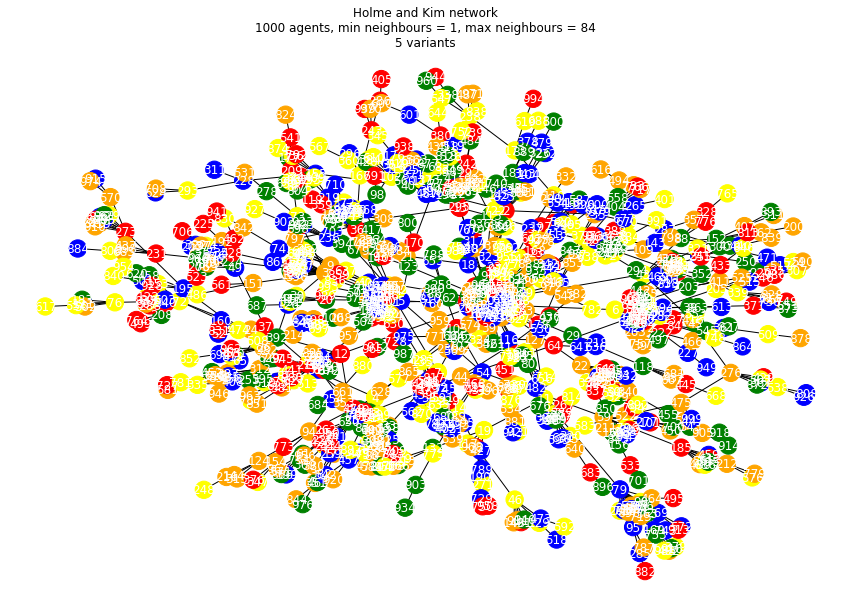

In [69]:
language_model = LanguageModel(1000, 1, 5, NetworkType.POWERLAW, ExchangeType.MULTIPLEX_POWER, [1, 3], draw_network=True)

Initialising model
Adding agents to model
Creating links
Initialising random regular network
Average multiplexity: 1.986
Minimum neighbours: 1
Maximum neighbours: 1
Network generation took 0.009388208389282227 seconds
Setting up exchange type
Poisson cache:
{'1': 0.4098085002803765, '2': 0.6804657420037286, '3': 0.8596408360245879}
Density: 0.001001001001001001
Drawing network


<Figure size 1080x720 with 0 Axes>

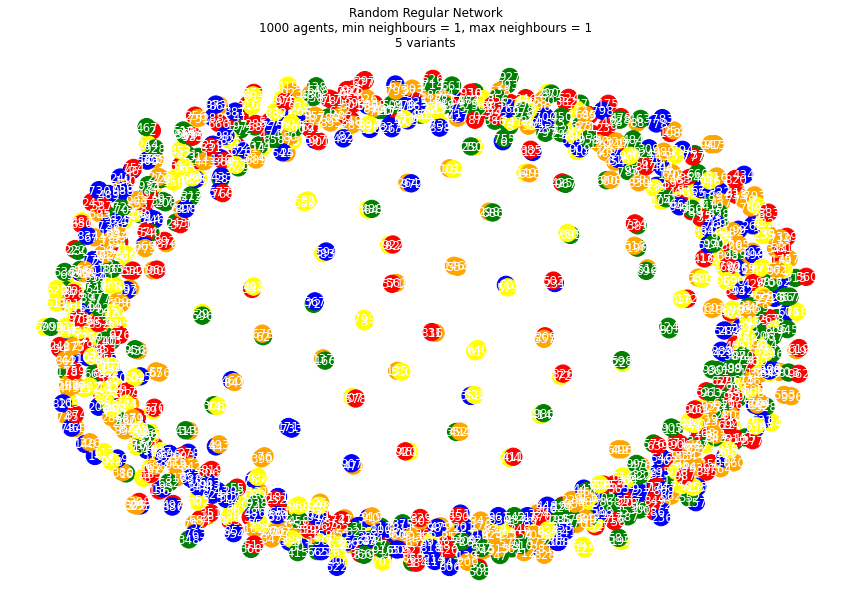

Drawing variant distribution


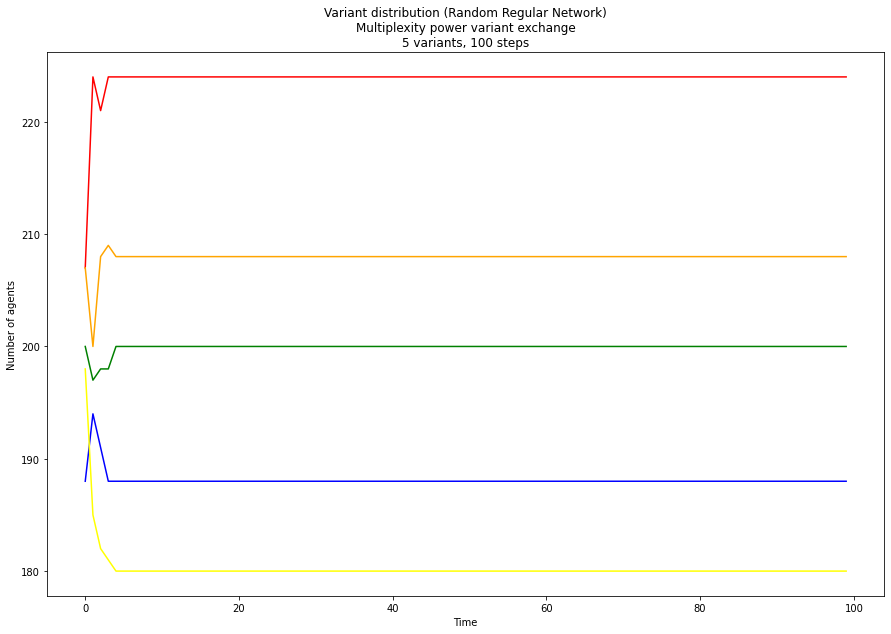

In [52]:
language_model = LanguageModel(1000, 1, 5, NetworkType.SIMPLE, ExchangeType.MULTIPLEX_POWER, [1, 3], draw_network=True)

for i in range(100):
    if not language_model.running:
        break
    
    language_model.step()
    
variant_distribution = language_model.variant_distribution.collect_dataframe()
visualisation = VariantDistributionVisualisation(language_model)
visualisation.draw()

Drawing neighbour count distribution


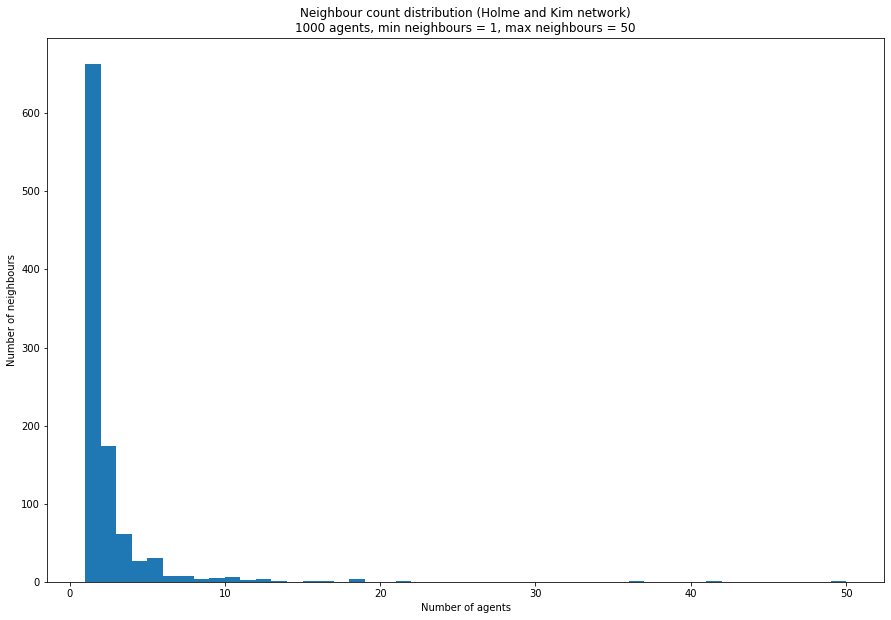

In [29]:
language_model.neighbour_visualisation.draw()

## Batch run

### Mixed network

In [28]:
mixed_fixed_parameters = { "num_agents": 1000,
                     "num_edges": 1,
                     "num_variants": 5,
                     "link_generator": NetworkType.POWERLAW,
                     "variant_exchange": ExchangeType.MULTIPLEX_POWER,
                     "multiplexity_range": [1, 3] }

mixed_batch_run = BatchRunnerMP(LanguageModel,
                          fixed_parameters=mixed_fixed_parameters,
                          iterations=500,
                          max_steps=5000,
                          model_reporters={ "standard_reached": RunOntologyCollection.standard_reached,
                                            "standard_lowest": RunOntologyCollection.derive_standard_lowest,
                                            "runner_up_highest": RunOntologyCollection.derive_runner_up_highest,
                                            "run_length": RunOntologyCollection.run_length },
                          nr_processes=4)

mixed_batch_run.run_all()
mixed_batch_run.get_model_vars_dataframe().to_csv("1_mixed_run.csv")

500it [5:14:03, 37.69s/it] 


Drawing run length


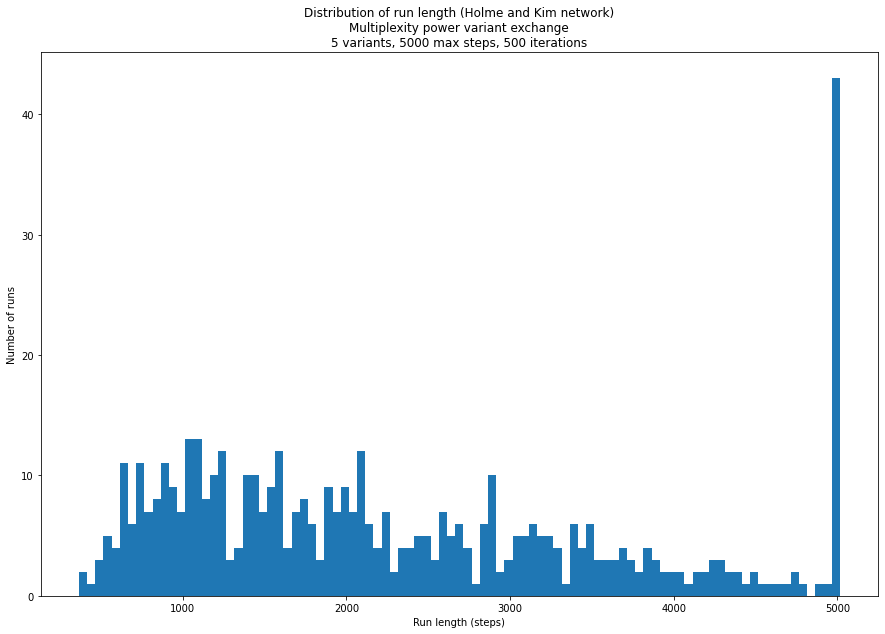

Drawing runner up highest


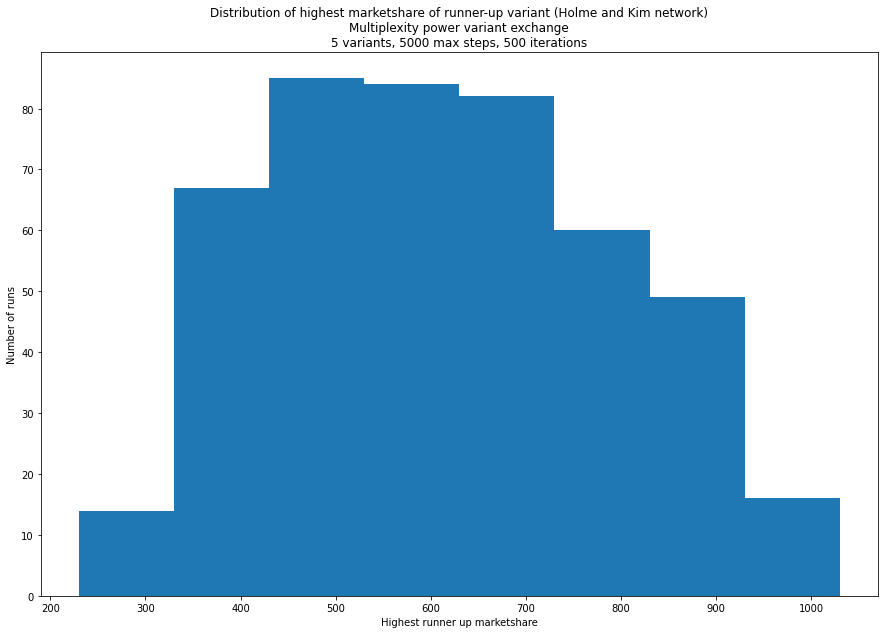

In [29]:
mixed_visualisation = RunOntologyVisualisation(mixed_batch_run)
mixed_visualisation.draw_run_length()
mixed_visualisation.draw_runner_up_highest()

### Weak network

#### Multiplexity exchange

In [30]:
weak_fixed_parameters = { "num_agents": 1000,
                     "num_edges": 1,
                     "num_variants": 5,
                     "link_generator": NetworkType.SIMPLE,
                     "variant_exchange": ExchangeType.MULTIPLEX_POWER,
                     "multiplexity_range": [1, 3] }

weak_batch_run = BatchRunnerMP(LanguageModel,
                          fixed_parameters=weak_fixed_parameters,
                          iterations=500,
                          max_steps=5000,
                          model_reporters={ "standard_reached": RunOntologyCollection.standard_reached,
                                            "standard_lowest": RunOntologyCollection.derive_standard_lowest,
                                            "runner_up_highest": RunOntologyCollection.derive_runner_up_highest,
                                            "run_length": RunOntologyCollection.run_length },
                          nr_processes=4)

weak_batch_run.run_all()
weak_batch_run.get_model_vars_dataframe().to_csv("1_weak_run.csv")

500it [11:13:48, 80.86s/it]


Drawing run length


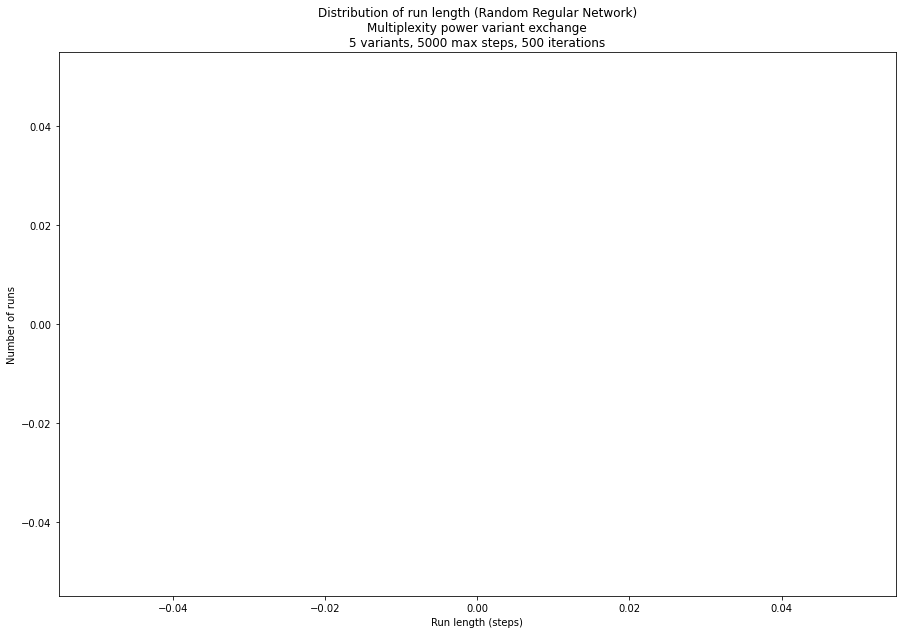

Drawing runner up highest


TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

<Figure size 1080x720 with 0 Axes>

In [32]:
weak_visualisation = RunOntologyVisualisation(weak_batch_run)
weak_visualisation.draw_run_length()
weak_visualisation.draw_runner_up_highest()

#### Fagyal exchange

In [33]:
weak_fg_fixed_parameters = { "num_agents": 1000,
                     "num_edges": 1,
                     "num_variants": 5,
                     "link_generator": NetworkType.SIMPLE,
                     "variant_exchange": ExchangeType.POWER,
                     "multiplexity_range": [1, 3] }

weak_fg_batch_run = BatchRunnerMP(LanguageModel,
                          fixed_parameters=weak_fg_fixed_parameters,
                          iterations=500,
                          max_steps=5000,
                          model_reporters={ "standard_reached": RunOntologyCollection.standard_reached,
                                            "standard_lowest": RunOntologyCollection.derive_standard_lowest,
                                            "runner_up_highest": RunOntologyCollection.derive_runner_up_highest,
                                            "run_length": RunOntologyCollection.run_length },
                          nr_processes=4)

weak_fg_batch_run.run_all()
weak_fg_batch_run.get_model_vars_dataframe().to_csv("1_weak_fg_run.csv")

500it [16:20:05, 117.61s/it]


Drawing run length


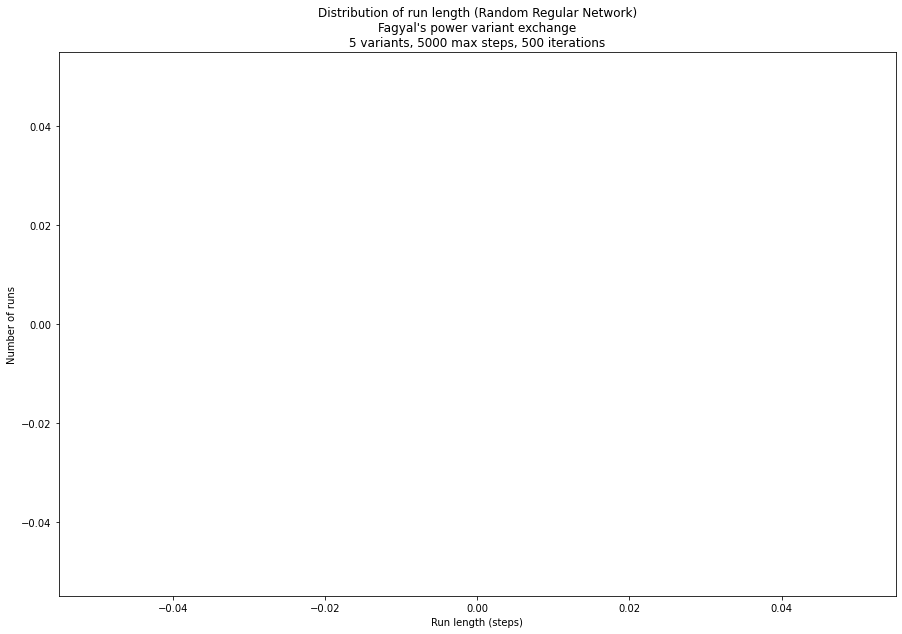

Drawing runner up highest


TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

<Figure size 1080x720 with 0 Axes>

In [34]:
weak_fg_visualisation = RunOntologyVisualisation(weak_fg_batch_run)
weak_fg_visualisation.draw_run_length()
weak_fg_visualisation.draw_runner_up_highest()

### Strong network

#### Multiplexity exchange

In [35]:
strong_fixed_parameters = { "num_agents": 1000,
                     "num_edges": 100,
                     "num_variants": 5,
                     "link_generator": NetworkType.SIMPLE,
                     "variant_exchange": ExchangeType.MULTIPLEX_POWER,
                     "multiplexity_range": [1, 3] }

strong_batch_run = BatchRunnerMP(LanguageModel,
                          fixed_parameters=strong_fixed_parameters,
                          iterations=500,
                          max_steps=5000,
                          model_reporters={ "standard_reached": RunOntologyCollection.standard_reached,
                                            "standard_lowest": RunOntologyCollection.derive_standard_lowest,
                                            "runner_up_highest": RunOntologyCollection.derive_runner_up_highest,
                                            "run_length": RunOntologyCollection.run_length },
                          nr_processes=4)

strong_batch_run.run_all()
strong_batch_run.get_model_vars_dataframe().to_csv("1_strong_run.csv")

500it [2:21:39, 17.00s/it]


Drawing run length


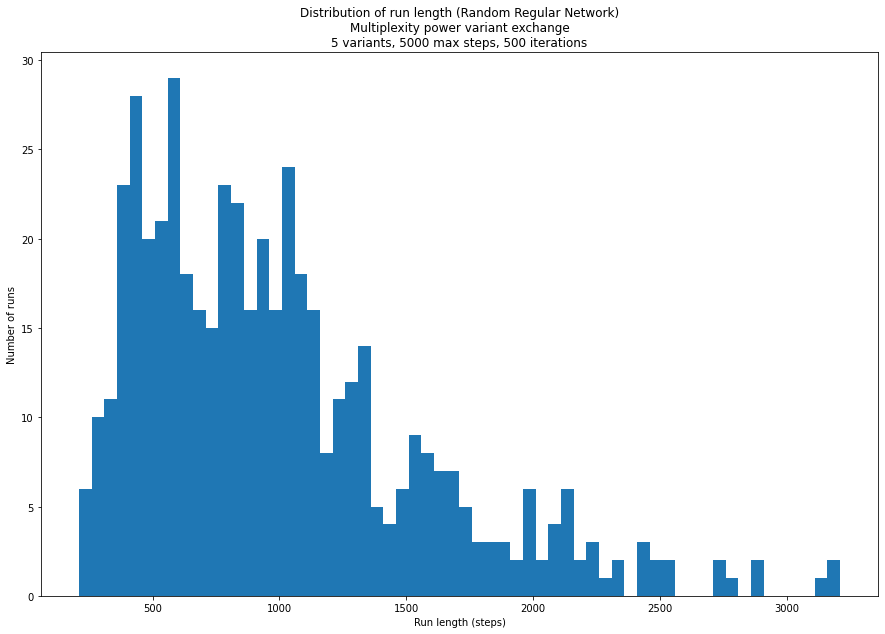

Drawing runner up highest


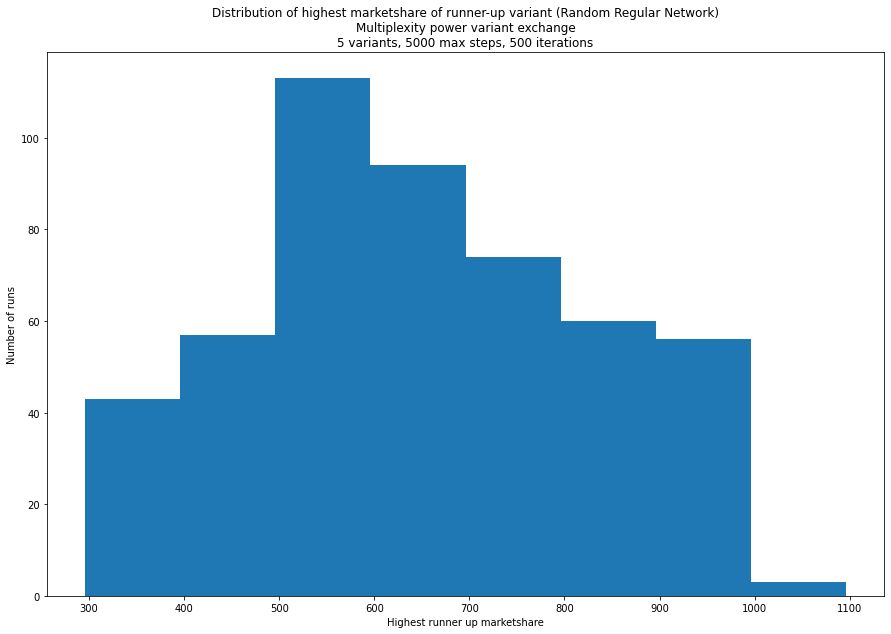

In [36]:
strong_visualisation = RunOntologyVisualisation(strong_batch_run)
strong_visualisation.draw_run_length()
strong_visualisation.draw_runner_up_highest()

#### Revised parameters

In [37]:
strong_rev_fixed_parameters = { "num_agents": 1000,
                     "num_edges": 3,
                     "num_variants": 5,
                     "link_generator": NetworkType.POWERLAW,
                     "variant_exchange": ExchangeType.MULTIPLEX_POWER,
                     "multiplexity_range": [1, 3] }

strong_rev_batch_run = BatchRunnerMP(LanguageModel,
                          fixed_parameters=strong_rev_fixed_parameters,
                          iterations=500,
                          max_steps=5000,
                          model_reporters={ "standard_reached": RunOntologyCollection.standard_reached,
                                            "standard_lowest": RunOntologyCollection.derive_standard_lowest,
                                            "runner_up_highest": RunOntologyCollection.derive_runner_up_highest,
                                            "run_length": RunOntologyCollection.run_length },
                          nr_processes=4)

strong_rev_batch_run.run_all()
strong_rev_batch_run.get_model_vars_dataframe().to_csv("1_strong_rev_run.csv")

500it [1:14:49,  8.98s/it]


Drawing run length


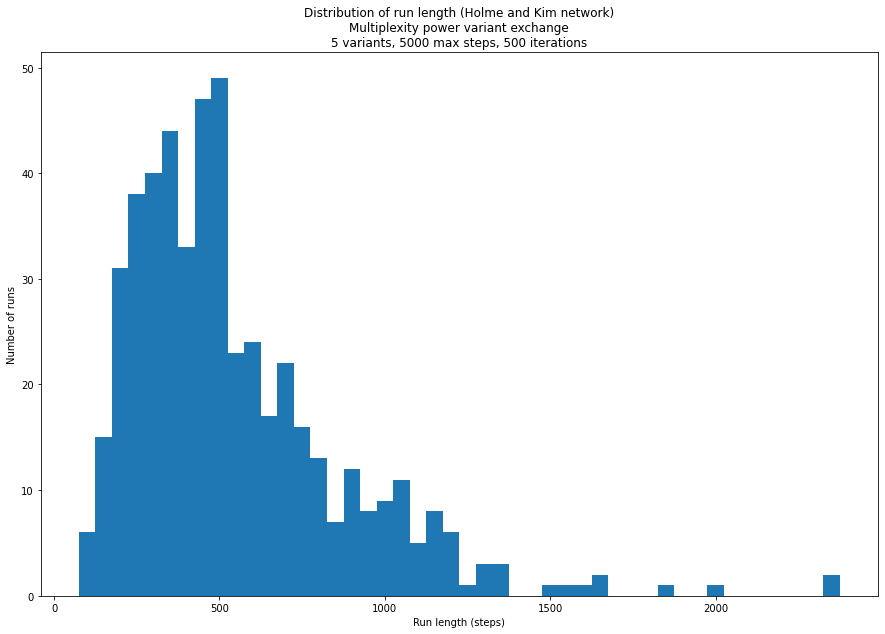

Drawing runner up highest


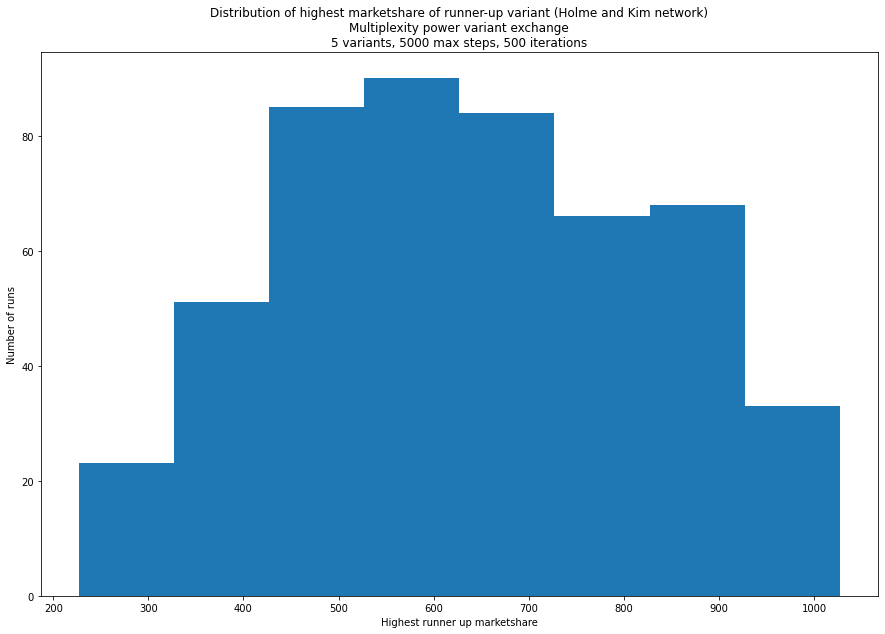

In [38]:
strong_rev_visualisation = RunOntologyVisualisation(strong_rev_batch_run)
strong_rev_visualisation.draw_run_length()
strong_rev_visualisation.draw_runner_up_highest()